# 🚖 IA - Homework 1 🚖
**👩 Alexandru Ioana  
 _📓 341C4_**
 
![Self driving cab](http://www.designmom.com/wp-content/uploads/2013/10/Google-Driverless-Taxi-Cab-537x389.jpg)

## Problem representation

The problem consists of **finding the optimal path of a cab which can pick up and drop off passengers on a given
map**. For a simple solution, we define helper classes with different functions.

### Coordinates

The `Coordinate` class offers a simple way of handling coordinates of problem variables (the car, passengers,
destinations).

In [1]:
class Coordinate(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return '<' + str(self.x) + ',' + str(self.y) + '>'

    def __eq__(self, other):
        if self is other:
            return True
        if not isinstance(other, Coordinate):
            return False
        return self.y == other.y and self.x == other.x

    def __repr__(self):
        return "Coordinate(%d, %d)" % (self.x, self.y)
    
    def __hash__(self):
        return hash(self.x) * 2 + hash(self.y) * 3

#### Manhattan distance

The **Manhattan distance** is the distance between two points measured along axes at right angles.

In order to calculate heuristics, we will need to calculate this distance between two coordinates.

![It's a surprise tool that will help us later](https://i.kym-cdn.com/photos/images/original/001/264/842/220.png)

In [2]:
def manhattan_distance(start, end):
    dx = abs(start.x - end.x)
    dy = abs(start.y - end.y)
    return dx + dy

### Actions

The `Action` enumeration defines all of the possible actions that the cab can take.

In [3]:
from enum import Enum

class Action(Enum):
    SOUTH = 'SOUTH'
    NORTH = 'NORTH'
    EAST = 'EAST'
    WEST = 'WEST'
    PICKUP = 'PICKUP'
    DROPOFF = 'DROPOFF'
    
    def __str__(self):
        return str(self.value)
    
    def __repr__(self):
        return str(self.value)

### Clients

The `Client` class represents the client in our problem. Each client has an initial (`start`) position on the map, a
`destination` they want to get to by taking a cab and a `budget` that they are willing to spend on the ride.

Two clients are the same (`__eq__`) if they share a destination, initial location and budget.

In [4]:
class Client(object):
    def __init__(self, start, destination, budget):
        self.start = start
        self.destination = destination
        self.budget = budget

    def __str__(self):
        return 'Client starts at ' + str(self.start) + \
               ', wants to get to ' + str(self.destination) + \
               ' and will spend at most ' + str(self.budget) + '.'

    def __eq__(self, other):
        if self is other:
            return True
        if not isinstance(other, Client):
            return False
        return self.start == other.start and\
               self.destination == other.destination and\
               self.budget == other.budget

    def __repr__(self):
        return "Client(%s, %s, %d)" % (str(self.start), str(self.destination), self.budget)
    
    def __hash__(self):
        return hash(self.start) * 2 + hash(self.destination) * 3 + hash(self.budget) * 5

### The cab

The `Cab` class represents a state of the single taxi cab in our problem. It has an initial `position` which can change
if it takes a movement action (`Action.NORTH`, `Action.SOUTH`, `Action.EAST`, `Action.WEST`) via the `do` method.
It also has an initial amount of `gas` (`max_gas`) which depletes by 1 unit with each movement.

The cab can hold either one or no `passenger` at a specific point in time. It can pick up a passenger when it is
located on the passenger's `start` position (`Action.PICKUP`), or drop off the passenger that is currently riding
(`Action.DROPOFF`) when it is located on the passenger's wanted `destination`, at which point the cab's `balance` will
increase by the passenger's `budget`.

Based on the map information, when in a specific position the cab can only take a specific set of actions, which can be
determined via the `get_available_actions` method.

Two different states of the cab are the same (`__eq__`) if they share the position, the passenger and the balance. The
actions taken as well as the amount of gas remaining are not taken into account in order to avoid running in circles.

In [5]:
from random import shuffle

class Cab(object):
    def __init__(self, position, gas):
        self.position = position
        self.passenger = None
        self.gas = gas
        self.max_gas = gas
        self.balance = 0
        self.actions = []
        
    def __str__(self):
        has_passenger = 'has a passenger' if self.passenger is not None else 'does not have a passenger'
        return 'Cab is at position ' + str(self.position) +\
               ', has ' + str(self.gas) + '/' + str(self.max_gas) +' gas, ' +\
               str(self.balance)+ '$ and ' + has_passenger + '.'

    def __eq__(self, other):
        if self is other:
            return True
        if not isinstance(other, Cab):
            return False
        return self.position == other.position and\
               self.passenger == other.passenger and\
               self.balance == other.balance

    def __repr__(self):
        return "Cab(%s)" % str(self.position)
    
    def __hash__(self):
        return hash(self.position) * 2 + hash(self.passenger is None) * 3
        
    ### Check if actions are possible
    
    def out_of_gas(self):
        return self.gas  == 0
            
    def get_available_actions(self, world):
        actions = []
        if not self.out_of_gas():
            if self.__can_dropoff(world):
                actions.append(Action.DROPOFF)
            if self.__can_pickup(world):
                actions.append(Action.PICKUP)
            if self.__can_go_east(world):
                actions.append(Action.EAST)
            if self.__can_go_west(world):
                actions.append(Action.WEST)
            if self.__can_go_south(world):
                actions.append(Action.SOUTH)
            if self.__can_go_north(world):
                actions.append(Action.NORTH)
        shuffle(actions)
        return actions
        
    def __can_go_west(self, world):
        grid_coords = Coordinate(self.position.x + 1, self.position.y * 2 + 1)
        return self.position.y > 0 and world.grid[grid_coords.x][grid_coords.y - 1] != '|'
        
    def __can_go_east(self, world):
        grid_coords = Coordinate(self.position.x + 1, self.position.y * 2 + 1)
        return self.position.y < world.width and world.grid[grid_coords.x][grid_coords.y + 1] != '|'
        
    def __can_go_north(self, world):
        return self.position.x > 0
        
    def __can_go_south(self, world):
        return self.position.x < world.height - 1
    
    def __can_pickup(self, world):
        return self.passenger is None and list(filter(lambda x : x.start == self.position, world.clients))
        
    def __can_dropoff(self, world):
        return self.passenger is not None and self.passenger.destination == self.position
    
    ### Do actions
    
    def do(self, action, world):
        self.actions.append(action)
        if action == Action.EAST:
            self.__go_east(world)
        elif action== Action.WEST:
            self.__go_west(world)
        elif action== Action.SOUTH:
            self.__go_south(world)
        elif action== Action.NORTH:
            self.__go_north(world)
        elif action== Action.PICKUP:
            self.__pickup(world)
        elif action== Action.DROPOFF:
            self.__dropoff(world)
    
    def __go_east(self, world):
        assert not self.out_of_gas() and self.__can_go_east(world)
        self.gas -= 1
        self.position.y += 1
    
    def __go_west(self, world):
        assert not self.out_of_gas() and self.__can_go_west(world)
        self.gas -= 1
        self.position.y -= 1
        
    def __go_south(self, world):
        assert not self.out_of_gas() and self.__can_go_south(world)
        self.gas -= 1
        self.position.x += 1
        
    def __go_north(self, world):
        assert not self.out_of_gas() and self.__can_go_north(world)
        self.gas -= 1
        self.position.x -= 1
        
    def __pickup(self, world):
        assert not self.out_of_gas() and self.__can_pickup(world)
        client = list(filter(lambda x : x.start == self.position, world.clients))[0]
        self.passenger = client
        world.clients.remove(client)
    
    def __dropoff(self, world):
        assert not self.out_of_gas() and self.__can_dropoff(world)
        self.balance += self.passenger.budget
        self.passenger = None
        

### The world

We are representing the problem as a state ***space search problem***. A specific state in our problem consists of the
map (`grid`), awaiting `clients` on the map, as well as a single `cab`. We will call this state our `world`.

Since it is a space search problem, it has the following properties:
- any given state can be **final** if there is no passenger riding and either no clients on the map or no gas in the
  tank (we can check whether a state is final by using the `goal()` method);
- from any given state, we can **transition** into a number of other states (which we can get by calling the transition
  function, `succ()`);
- a state has a specific **cost** associated with it, representing the amount of gas spent from the initial state up to
  the given state, which we can obtain by calling `g()`.

We consider two separate states of the problem to be the same when the state of the cab is the same (see
[The cab](#The-cab)) and the list of awaiting clients is the same.

In [6]:
# coding=utf-8
from copy import deepcopy, copy

use_emojis = True
class World(object):
    def __init__(self, grid, cab, clients):
        self.width = len(grid[0]) // 2
        self.height = len(grid) - 2
        self.grid = grid
        self.cab = cab
        self.clients = clients

    def __str__(self):
        string = ''
        for i, line in enumerate(self.grid, start=0):
            for j, cell in enumerate(line, start=0):
                coords = Coordinate(i - 1, j // 2)
                if j % 2 == 0 and list(filter(lambda x: x.start == coords, self.clients)):
                    string += '🚶' if use_emojis else 'C'
                elif j % 2 == 0 and self.cab.passenger is not None and self.cab.passenger.destination == coords:
                    string += '🚏' if use_emojis else 'D'
                elif j % 2 == 1 and self.cab.position == coords:
                    string += '🚘️' if use_emojis else 'T'
                elif i == j == 0:
                    string += '┏'
                elif i == 0 and j == len(line) - 1:
                    string += '┓'
                elif i == len(self.grid) - 1 and j == 0:
                    string += '┗'
                elif i == len(self.grid) - 1 and j == len(line) - 1:
                    string += '┛'
                elif cell == '|':
                    string += '┃'
                elif cell == ':':
                    string += '┆'
                elif cell == '-':
                    if i > 0 and self.grid[i - 1][j] != ' ':
                        string += '┻'
                    elif i < len(self.grid) - 1 and self.grid[i + 1][j] != ' ':
                        string += '┳'
                    else:
                        string += '━'
                else:
                    string += cell
            string += '\n'
        return string

    def __repr__(self):
        return str(self)
    
    def __eq__(self, other):
        if self is other:
            return True
        if not isinstance(other, World):
            return False
        return self.cab == other.cab and set(self.clients) == set(other.clients)
    
    def __hash__(self):
        return hash(self.cab)
    
    def goal(self):
        return self.cab.passenger is None and\
                (len(self.clients) == 0 or\
                 self.cab.out_of_gas())
    
    def succ(self):
        states = []
        actions = self.cab.get_available_actions(self)
        for action in actions:
            cab_copy = deepcopy(self.cab)
            clients_copy = copy(self.clients)
            next = World(self.grid, cab_copy, clients_copy)
            cab_copy.do(action, next)
            states.append(next)
        return states
    
    def g(self):
        return self.cab.max_gas - self.cab.gas
    
    def h(self):
        return 0

## I/O operations

In addition to implementing the `__str__` and `__repr__` methods for all of our classes, we will define functions for
reading and writing of the problem data.

### Reading

The `read_data` function opens the file with the given `filename` and turns the data inside it into an instance of
`World`.

In [7]:
def read_data(filename):
    with open(filename, 'r') as f:
        height, width, gas = [int(x) for x in next(f).split()]
        car_position_y, car_position_x = [int(x) for x in next(f).split()]
        cab = Cab(Coordinate(car_position_x, car_position_y), gas)
        
        client_count = int(next(f))
        clients = []
        for i in range(client_count):
            start_y, start_x, destination_y, destination_x, budget = [int(x) for x in next(f).split()]
            clients.append(Client(Coordinate(start_x, start_y), Coordinate(destination_x, destination_y), budget))

        grid = []
        for i in range(height + 2):
            grid.append(list(next(f).rstrip()))
            
        return World(grid, cab, clients)

### Writing

The solution of our problem consists of a final state, a dictionary of parents and, optionally, a list of visited
states. We have multiple ways of displaying that result.

#### Listing

The `print_result` function lists each step defined in a solution, from the initial state up to the final one. 

In [8]:
def print_result(state, parents, closed=None):
    next = parents[state]
    if next is not None:
        print_result(next, parents)
    print(state)

#### Animating

The `animate_result` function works similarly with `print_result`, except it only shows each frame (step) for 0.4
seconds before clearing the display and showing the following frame.

In [9]:
from IPython.core.display import clear_output
import time

def animate_result(state, parents, closed=None):
    next = parents[state]
    if next is not None:
        print_result(next, parents)
    string = str(state)
    clear_output()
    print(string)
    time.sleep(0.4)

## Search algorithms

We will solve the problem using different search algorithms (both informed and uninformed) in order to compare their
performance, caveats and particularities.

While we can represent the solution in an intuitive way by drawing the map at each step (see [Writing](#Writing)), that
can quickly become impractical for more complex inputs. A simpler way of representing a discovered solution is with a
list of actions in the order that they are to be taken by the cab, as well as the total cost of that set of actions.
That is what the `get_solution` function is doing.

In [137]:
def get_solution(state, parents=None, closed=None):
    if state is None:
        return None
    actions = state.cab.actions
    cost = state.g()
    return actions, cost

Additionally, not all solutions are equivalent. We can evaluate the quality of a solution by adding the remaining fuel
and the final balance:

In [11]:
def evaluate_solution(state, parents=None, closed=None):
    return state.cab.gas + state.cab.balance

If we have a list of visited states, we can analyze the number of visited states by calling:

In [12]:
def visited_states(state, parents, closed):
    return len(closed)

We will analyze the algorithms as we go by calling them on the sample situation defined in `input`.

In [180]:
world = read_data('input')
print(world)

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃🚘️┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛



### Uninformed search strategies

An **uninformed search** is a searching technique that has _no additional information about the distance from the
current state to the goal_.

#### Breadth-first search

**Breadth-first search (BFS)** is an algorithm which starts at the initial state _s0_ and explores all of the possible
states that can be transitioned to at the present depth prior to moving on to the states at the next depth level. 

A naïve implementation of BFS simply adds all states that can be explored to the back of a queue (we will also make sure
not to have duplicates in the queue, since it would be unbearably slow otherwise). This only works because `succ`
returns the neighbors in a random order, otherwise it would cycle between two cells until out of gas.

In [13]:
def bfs(world):
    open = [world]
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents
        for next in current.succ():
            if next not in open:
                parents[next] = current
                open.append(next)
    return None

A simple way of optimizing this algorithm is by saving the visited nodes and not processing them again:

In [80]:
def optimized_bfs(world):
    open = [world]
    closed = []
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents, closed
        for next in current.succ():
            if next not in open and next not in closed:
                parents[next] = current
                open.append(next)
        closed.append(current)
    return None

The best solution to the sample input is easy to find:

In [190]:
print_result(*optimized_bfs(world))

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃🚘️┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆🚘️┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃🚘️┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃🚘️┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶🚘️┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
🚏 ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┃🚘️┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
🚏 ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃🚘️┃ ┆ ┃ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
🚏 ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃🚘️┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
🚏 ┆ ┃ ┆ ┆ ┃
┃🚘️┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
🚏🚘️┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃🚘️┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛



Let's check that both algorithms lead to the same solution:

In [15]:
bfs1 = get_solution(*bfs(world))
bfs2 = get_solution(*optimized_bfs(world))
assert bfs1 == bfs2
print(bfs1)

([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


Now let's compare their performance:

In [16]:
%timeit bfs(world)
%timeit optimized_bfs(world)

18.1 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.17 ms ± 336 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see, the optimized version is significantly faster. That is due to the fact that the naïve version is likely
to check the same state multiple times, hence wasting time without gaining any additional information.

#### Uniform cost search

**Uniform Cost Search (UCS)** is similar to **BFS**, except instead of exploring each state in the order it was
discovered, it prioritizes exploring the states which have a lower cost associated with them (in our case, a lower
amount of gas used by the cab in order to arrive to that state, or `g()`) by using a priority queue.

In [17]:
# Using heapq to implement the priority queue
import heapq

In [18]:
# Define a sub-class which orders instances based on g()
class UniformWorld(World):
    def __lt__(self, other):
        return self.g() < other.g()

As with **BFS**, we can have the naïve implementation:

In [19]:
def ucs(world):
    open = [world]
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents
        for next in current.succ():
            if next not in open:
                parents[next] = current
                # heapq uses the __lt__ method to sort the states
                next.__class__ = UniformWorld
                heapq.heappush(open, next)
    return None

And the optimized one:

In [20]:
def optimized_ucs(world):
    open = [world]
    closed = []
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents, closed
        for next in current.succ():
            if next not in open and next not in closed:
                parents[next] = current
                # heapq uses the __lt__ method to sort the states
                next.__class__ = UniformWorld
                heapq.heappush(open, next)
        closed.append(current)
    return None

As before, both versions should lead to the same solution:

In [21]:
ucs1 = get_solution(*ucs(world))
ucs2 = get_solution(*optimized_ucs(world))
assert ucs1 == ucs2
print(ucs1)

([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


Now let's compare their performance:

In [22]:
%timeit ucs(world)
%timeit optimized_ucs(world)

13.7 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.42 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As expected, the optimized algorithm is significantly faster.

#### Depth-first search

**Depth-first search (DFS)** is different from **BFS** in that it explores as far (deep) as possible along each path
before backtracking.

This behaviour can be obtained by using a stack instead of a queue (or in our case, inserting elements at the beginning
of the list):

In [23]:
def dfs(world):
    open = [world]
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents
        for next in current.succ():
            if next not in open:
                parents[next] = current
                open.insert(0, next)
    return None

We can once again optimize by saving the visited states:

In [24]:
def optimized_dfs(world):
    open = [world]
    closed = []
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents, closed
        for next in current.succ():
            if next not in open and next not in closed:
                parents[next] = current
                open.insert(0, next)
        closed.append(current)
    return None

This time, the naïve implementation's solution will most likely just be running around until out of gas, while the
optimized solution will offer a solution which might not always be the most cost-efficient one. This behaviour is due to
the fact that **DFS** will return the first final state it reaches, which will usually not be the most cost-effective
one because `succ` returns the following states in a random order.

In [25]:
dfs1 = get_solution(*dfs(world))
dfs2 = get_solution(*optimized_dfs(world))
print(dfs1)
print(dfs2)

([EAST, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH, NORTH, SOUTH], 100)
([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


The performance difference is even more obvious here:

In [26]:
%timeit -r7 -n10 dfs(world)
%timeit -r7 -n10 optimized_dfs(world)

14.8 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.22 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Depth-limited search

**Depth-limited search (DLS)** improves upon **DFS** by that it limits the maximum depth that the algorithm can get to,
in order to avoid recursing infinitely in case the goal is unreachable or going too far onto the wrong path.

The caveat that this version adds is the fact that, if the cutoff is too low, we may encounter a "false" failure caused
by the goal not being reachable within the set depth.

> ***NOTE:*** Our problem is technically already depth-limited by design, since the cab cannot move more than its gas
> tank allows it to move. It could still make a virtually unlimited amount of PICKUP/DROPOFF actions, but since the
> number of clients on the map is also finite, that is not possible either.

The naïve solution:

In [27]:
def dls(world, k):
    open = [(0, world)]
    parents = {world : None}
    while len(open) > 0:
        depth, current = open.pop(0)
        if current.goal():
            return current, parents
        if depth >= k:
            continue
        for next in current.succ():
            if next not in [x[1] for x in open]:
                parents[next] = current
                open.insert(0, (depth + 1, next))
    return None

The optimized solution:

In [110]:
def optimized_dls(world, k):
    open = [(0, world)]
    closed = []
    parents = {world : None}
    while len(open) > 0:
        depth, current = open.pop(0)
        if current.goal():
            return current, parents, closed
        if depth >= k:
            continue
        for next in current.succ():
            if (next not in [x[1] for x in open]) and (next not in closed):
                parents[next] = current
                open.insert(0, (depth + 1, next))
        closed.append(current)
    return None, parents, closed

Four our sample data, we already know that the ideal sequence of actions has a length of 10 and a cost of 8, therefore
`k = 10` should be deep enough for us to find this solution:

In [31]:
dls1 = get_solution(*dls(world, 10))
dls2 = get_solution(*optimized_dls(world, 10))
assert dls1 == dls2
print(dls1)

([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


As we can see, this time both the naïve and the optimized versions eventually reach the same (good) solution thanks to
the cutoff value, which prevents them from going in the wrong direction.

Now for the performance:

In [111]:
%timeit dls(world, 10)
%timeit optimized_dls(world, 10)

329 ms ± 74.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.82 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Since the naïve solution is likely to go off track many times before finally finding the good solution, it is incredibly
slow compared to the optimized one.

#### Iterative deepening search

**Iterative deepening search** takes **DLS** one step further by incrementally trying different values for the depth
until a solution is found.

We can use the simple **DLS** algorithm:

In [139]:
def ids(world):
    k = 0
    while True:
        result = dls(world, k)
        if result is not None:
            return result
        k += 1

Or the optimized one:

In [143]:
def optimized_ids(world):
    k = 0
    visited = []
    while True:
        state, parents, closed = optimized_dls(world, k)
        visited += closed
        if state is not None:
            return state, parents, visited
        k += 1

We "cheated" earlier since we already knew a good value for `k`. However, most of the time we won't know the value
beforehand, so the best way to find the minimum value of `k` as well as the best solution is to increment `k` and keep
trying **DLS** until we succeed. We already know that we'll reach a good solution here when k becomes 10:

In [144]:
ids1 = get_solution(*ids(world))
ids2 = get_solution(*optimized_ids(world))
assert ids1 == ids2
print(ids1)

([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


As for the performance, it is slow compared to the other algorithms since it involves running **DLS** multiple times:

In [145]:
%timeit ids(world)
%timeit optimized_ids(world)

1.1 s ± 235 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.5 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Informed search strategies

**Informed search strategies** use additional information about states (heuristics - `h()` - which estimate how far from
the goal a given state is) that have not yet been explored to decide which state to examine next.

One possible heuristic for our problem is the Manhattan distance from the current position of the cab to either the
clients's destination (if the cab has a passenger), or the closest potential client:

In [37]:
def h1(world):
    if world.goal():
        return 0
    if world.cab.passenger is not None:  # distance to the passenger's destination
        return manhattan_distance(world.cab.position, world.cab.passenger.destination)
    else:  # distance to the closest potential client
        return min(manhattan_distance(world.cab.position, client.start) for client in world.clients)

Another heuristic could also take into account the client's budget in addition to the distance (the higher the budget,
the lower the impact a longer distance will have on the cost):

In [38]:
def h2(world):
    if world.goal():
        return 0
    if world.cab.passenger is not None:  # distance to the passenger's destination
        return manhattan_distance(world.cab.position, world.cab.passenger.destination)
    else:  # distance to the closest potential client divided by their budget
        return min(manhattan_distance(world.cab.position, client.start) / client.budget for client in world.clients)

We can further improve both of these heuristics by also taking into account the distance from the client's initial
location to their destination:

In [234]:
def h3(world):
    if world.goal():
        return 0
    if world.cab.passenger is not None:  # distance to the passenger's destination
        return manhattan_distance(world.cab.position, world.cab.passenger.destination)
    else:  # minimum distance to client + destination
        return min(manhattan_distance(world.cab.position, client.start) +\
                   manhattan_distance(client.start, client.destination)
                   for client in world.clients)

In [235]:
def h4(world):
    if world.goal():
        return 0
    if world.cab.passenger is not None:  # distance to the passenger's destination
        return manhattan_distance(world.cab.position, world.cab.passenger.destination)
    else:  # minimum (distance to client + destination) divided by their budget
        return min((manhattan_distance(world.cab.position, client.start) +\
                    manhattan_distance(client.start, client.destination)) /\
                   client.budget for client in world.clients)

#### Greedy best-first search

The **Greedy best-first search** algorithm is similar to **UCS**, except that it uses heuristics. Instead of selecting
the state closest to the starting point, it selects the state closest to the goal. **GBFS** is not guaranteed to find
the most cost-efficient path. However, it runs much quicker than **UCS** because it uses the heuristic function to guide
its way towards the goal very quickly.

In [39]:
# Define a sub-class which orders instances based on h()
class GreedyWorld(World):
    def __lt__(self, other):
        return self.h() < other.h()

Since it is similar to **UCS**, it also has a naïve solution:

In [40]:
def gbfs(world, heuristic):
    World.h = heuristic
    open = [world]
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents
        for next in current.succ():
            if next not in open:
                parents[next] = current
                # heapq uses the __lt__ method to sort the states
                next.__class__ = GreedyWorld
                heapq.heappush(open, next)
    return None

As well as an optimized one:

In [41]:
def optimized_gbfs(world, heuristic):
    World.h = heuristic
    open = [world]
    closed = []
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents, closed
        for next in current.succ():
            if next not in open and next not in closed:
                parents[next] = current
                # heapq uses the __lt__ method to sort the states
                next.__class__ = GreedyWorld
                heapq.heappush(open, next)
        closed.append(current)
    return None

On our sample data, like the unoptimized **DFS**, the unoptimized **GBFS** goes into a loop since, because it only takes
into account the Manhattan distance between a state and the destination (be it the closest client or the passenger's
destination) and there is an obstacle between the initial state and the closest client, making it keep moving between
two states which don't allow it to reach the client.

The optimized version, however, quickly reaches the solution:

In [42]:
gbfs1 = get_solution(*gbfs(world, h1))
gbfs2 = get_solution(*optimized_gbfs(world, h1))
print(gbfs1)
print(gbfs2)

([SOUTH, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST, WEST, EAST], 100)
([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


The performance is very good:

In [43]:
%timeit gbfs(world, h1)
%timeit optimized_gbfs(world, h1)

23.5 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.14 ms ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### A* search

A* combines heuristic approaches like **GBFS** and formal approaches like **UCS**. Unlike the majority of heuristic
approaches, which usually give you an approximate way to solve problems without guaranteeing that you get the best
answer, A* can guarantee a shortest path, even though the heuristic itself does not give any guarantees.

In [44]:
# Define a sub-class which orders instances based on both g() and h()
class SmartWorld(World):
    def __lt__(self, other):
        return self.g() + self.h() < other.g() + other.h()

The unoptimized A* is:

In [45]:
def a_star(world, heuristic):
    World.h = heuristic
    open = [world]
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents
        for next in current.succ():
            if next not in open:
                parents[next] = current
                # heapq uses the __lt__ method to sort the states
                next.__class__ = SmartWorld
                heapq.heappush(open, next)
    return None

And the optimized version is:

In [46]:
def optimized_a_star(world, heuristic):
    World.h = heuristic
    open = [world]
    closed = []
    parents = {world : None}
    while len(open) > 0:
        current = open.pop(0)
        if current.goal():
            return current, parents, closed
        for next in current.succ():
            if next not in open and next not in closed:
                parents[next] = current
                # heapq uses the __lt__ method to sort the states
                next.__class__ = SmartWorld
                heapq.heappush(open, next)
        closed.append(current)
    return None

Since the cost takes into account both distance and gas cost, both versions will reach a good solution:

In [47]:
a_star1 = get_solution(*a_star(world, h1))
a_star2 = get_solution(*optimized_a_star(world, h1))
print(a_star1)
print(a_star2)

([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)
([NORTH, WEST, SOUTH, SOUTH, PICKUP, NORTH, NORTH, NORTH, NORTH, DROPOFF], 8)


The optimized algorithm is very fast, but the unoptimized one is not too bad either:

In [48]:
%timeit a_star(world, h1)
%timeit optimized_a_star(world, h1)

8.04 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.36 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Hill-climbing search

**Hill-climbing** algorithm is a local search algorithm which continuously moves in the direction of increasing
elevation/value to find the peak of the mountain or best solution to the problem. It terminates when it reaches a peak
value where no neighbor has a higher value.

Since our problem is a cost-minimization problem, **HCS** will not help in finding a good solution, but instead will
just go as far as possible from the nearest client. Even if, instead of the cost, we would use the evaluation of a
potential solution (i.e. `evaluate_solution(current)` instead of `current.g() + current.h()`, the algorithm would still
not reach a solution as it would simply stay in place no matter the state (since moving would mean spending gas, which
lowers the value).

The 'standard' **HCS** implementation is the following:

In [49]:
def hcs(world, heuristic):
    World.h = heuristic
    current = world
    parents = {world : None}
    done = False
    current_cost = current.g() + current.h()
    while not done:
        maximum = current_cost
        next_state = None
        for next in current.succ():
            cost = next.g() + next.h()
            if cost > maximum:
                maximum = cost
                next_state = next
        if next_state is None:
            done = True
        else:
            parents[next_state] = current
            current = next_state
            current_cost = maximum
    return current, parents

We can marginally improve it by saving the visited states, as with the previous algorithms:

In [50]:
def optimized_hcs(world, heuristic):
    World.h = heuristic
    current = world
    parents = {world : None}
    done = False
    current_cost = current.g() + current.h()
    closed = []
    while not done:
        maximum = current_cost
        next_state = None
        for next in current.succ():
            if next in closed:
                continue
            cost = next.g() + next.h()
            if cost > maximum:
                maximum = cost
                next_state = next
        closed.append(current)
        if next_state is None:
            done = True
        else:
            parents[next_state] = current
            current = next_state
            current_cost = maximum
    return current, parents, closed

As expected, the cab is just 'running away' from the client, since the local maximum cost is reached when the sum
between the spent gas and the distance to the nearest client is the highest:

In [189]:
print_result(*hcs(world, h1))

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃🚘️┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆🚘️┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆🚘️┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆🚘️┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
┃ ┆ ┆ ┆🚘️┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆🚘️┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆🚘️┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
🚶 ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛



Both algorithms should lead to the same solution:

In [51]:
world = read_data('input')
hcs1 = get_solution(*hcs(world, h1))
hcs2 = get_solution(*optimized_hcs(world, h1))
print(hcs1)
print(hcs2)

([NORTH, EAST, NORTH, NORTH, EAST, EAST], 6)
([EAST, NORTH, NORTH, EAST, NORTH, EAST], 6)


As well as being much faster than the other algorithms thanks to always checking just the local maximum, which leads to
it never picking up a client:

In [52]:
%timeit hcs(world, h1)
%timeit optimized_hcs(world, h1)

668 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
732 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Comparative analysis

We will be analyzing the above strategies in terms of performance (based on the running time), quality of results (using
`evaulate_solution`) and number of explored states (`visited_states`) on the data in the `tests` folder.

In [53]:
times = {}
quality = {}
visited = {}

We will use the following code to plot the results:

In [248]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_algorithms(data, label,xlim=[0, 5],ylim=None):
    algorithms = ['BFS', 'DFS', 'UCS', 'IDS']
    plt.figure(figsize=(15,15))
    for a in algorithms:
        plt.plot(a, data=data, label=a)
    colors = ['C4', 'C5', 'C6']
    linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
    algorithms = ['GBFS', 'A*', 'HCS']
    for i, l in enumerate(linestyles):
        numbered_algorithms = list(map(lambda a: str(a) + str(i + 1), algorithms))
        for a, c in zip(numbered_algorithms, colors):
            plt.plot(a, data=data, label=a, linestyle=l, color=c)

    plt.xlabel('input')
    plt.xlim(xlim)
    plt.ylabel(label)
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend()
    plt.show()

### Data

The initial states we will be analyzing are the following:

In [55]:
data = [read_data(filename) for filename in ['tests/test' + str(x) + '.in' for x in range(1, 7)]]
use_emojis = False
for i, d in enumerate(data):
    print(str(i) + ') ' + str(d.cab))
    print(d)

0) Cab is at position <2,2>, has 5/5 gas, 0$ and does not have a passenger.
┏━┳━┳━┳━┳━┓
┃ ┆ ┃ ┆ ┆ ┃
C C ┆ ┆ ┆ ┃
┃ ┆ CT┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

1) Cab is at position <1,2>, has 15/15 gas, 0$ and does not have a passenger.
┏━┳━┳━┳━┳━┓
┃ C C ┆ C ┃
C C ┆T┆ C ┃
C C C ┆ ┆ ┃
┃ ┃ ┆ C ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

2) Cab is at position <1,2>, has 20/20 gas, 0$ and does not have a passenger.
┏━┳━┳━┳━┳━┓
┃ C C ┆ C ┃
C C ┆T┆ C ┃
C C C ┆ ┆ ┃
┃ ┃ ┆ C ┆ ┃
┃ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┛

3) Cab is at position <5,1>, has 20/20 gas, 0$ and does not have a passenger.
┏━┳━┳━┳━┳━┳━┳━┓
┃ C C ┆ ┆ ┃ ┆ ┃
┃ ┆ ┆ ┆ ┆ C ┆ ┃
┃ C ┆ ┆ ┆ ┆ ┆ ┃
┃ ┃ ┆ ┃ ┆ ┆ ┃ ┃
┃ ┃ C ┃ ┆ ┆ ┆ ┃
┃ CT┆ ┆ ┆ ┆ ┆ ┃
C ┆ ┆ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┻━┻━┛

4) Cab is at position <5,1>, has 25/25 gas, 0$ and does not have a passenger.
┏━┳━┳━┳━┳━┳━┳━┓
┃ C C ┆ ┆ ┃ ┆ ┃
┃ ┆ ┆ ┆ ┆ C ┆ ┃
┃ C ┆ ┆ ┆ ┆ ┆ ┃
┃ ┃ C ┃ ┆ ┆ ┃ ┃
┃ ┃ C ┃ ┆ ┆ ┆ ┃
┃ CT┆ ┆ ┆ ┆ ┆ ┃
C ┆ ┆ ┃ ┆ ┃ ┆ ┃
┗━┻━┻━┻━┻━┻━┻━┛

5) Cab is at position <8,3>, has 25/25 gas, 0$ and does not have a 

### Performance

Let's run all of the strategies on all of the inputs several times and calculate the average time:

In [163]:
def time_algorithm(function, state, heuristic=None):
    timeitresult = 0
    if heuristic is None:
        timeitresult = %timeit -o -q -r3 -n3 function(state)
    else:
        timeitresult = %timeit -o -q -r3 -n3 function(state, heuristic)
    return sum(timeitresult.all_runs) / len(timeitresult.all_runs)

In [164]:
times['BFS'] = list(map(lambda x: time_algorithm(optimized_bfs, x), data))

In [165]:
times['DFS'] = list(map(lambda x: time_algorithm(optimized_dfs, x), data))

In [166]:
times['UCS'] = list(map(lambda x: time_algorithm(optimized_ucs, x), data))

In [167]:
times['IDS'] = list(map(lambda x: time_algorithm(optimized_ids, x), data))

In [168]:
times['GBFS1'] = list(map(lambda x: time_algorithm(optimized_gbfs, x, h1), data))

In [169]:
times['GBFS2'] = list(map(lambda x: time_algorithm(optimized_gbfs, x, h2), data))

In [236]:
times['GBFS3'] = list(map(lambda x: time_algorithm(optimized_gbfs, x, h3), data))

In [237]:
times['GBFS4'] = list(map(lambda x: time_algorithm(optimized_gbfs, x, h4), data))

In [170]:
times['A*1'] = list(map(lambda x: time_algorithm(optimized_a_star, x, h1), data))

In [171]:
times['A*2'] = list(map(lambda x: time_algorithm(optimized_a_star, x, h2), data))

In [244]:
times['A*3'] = list(map(lambda x: time_algorithm(optimized_a_star, x, h3), data))

In [245]:
times['A*4'] = list(map(lambda x: time_algorithm(optimized_a_star, x, h4), data))

In [172]:
times['HCS1'] = list(map(lambda x: time_algorithm(optimized_hcs, x, h1), data))

In [173]:
times['HCS2'] = list(map(lambda x: time_algorithm(optimized_hcs, x, h2), data))

In [246]:
times['HCS3'] = list(map(lambda x: time_algorithm(optimized_hcs, x, h3), data))

In [247]:
times['HCS4'] = list(map(lambda x: time_algorithm(optimized_hcs, x, h4), data))

Now to plot the data we just gathered:

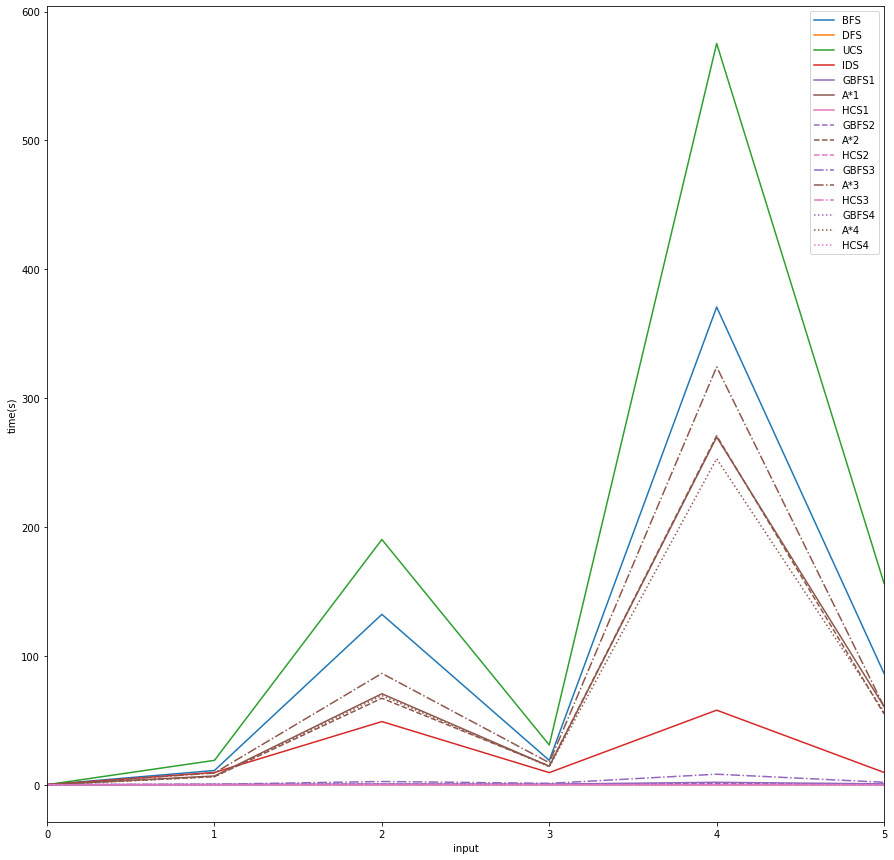

In [249]:
%matplotlib inline
plot_algorithms(times, 'time(s)')

We can now clearly see that **UCS** is the slowest, followed by **BFS**, then **A*** and then **IDS**. The third
heuristic seems to make A* slower, while the other 3 have a similar performance, with `h1` marginally faster than `h2`,
and `h2` & `h4` having a similar performance.

The overall fastest algorithms are **DFS**, **HCS** and **GBFS**, but in order to compare them we need a different
graph:

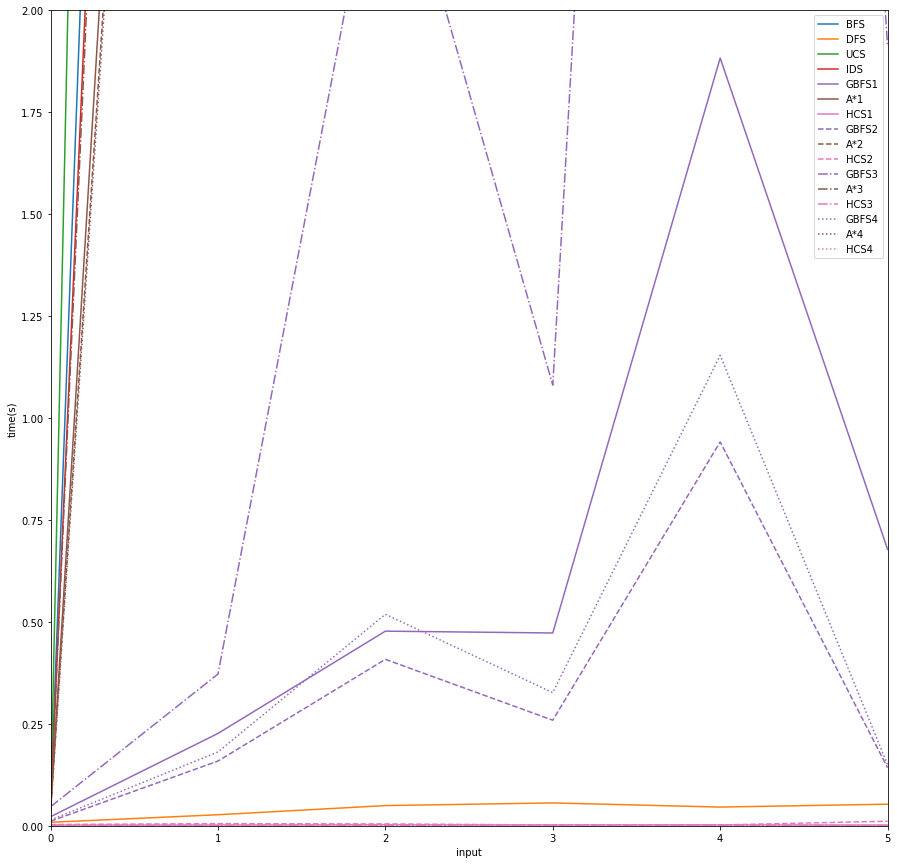

In [258]:
%matplotlib inline
plot_algorithms(times, 'time(s)', [0, 5], [0, 2])

As expected, **HCS** has a nearly constant time, since, as mentioned before, it only checks the local maximum and
reaches a solution quickly. **DFS** is not too far behind, since it just goes with the first 'final' state found. For
both algorithms, the time is only affected by the maximum amount of gas and the size of the map, since the final state
will be reached marginally more slowly.

While still much faster than the otrher algorithms, **GBFS** makes more effort to reach a good solution. Like with A*,
the third heuristic seems to make it slower, while the other 3 have a very similar performance.

### Quality

Speed is not the only relevant factor. As we've seen before, different algorithms will yield different results. We will
check the quality of these results by calling `evaluate_solution`, which sums up the remaining gas and the money.

In [278]:
quality['BFS'] = list(map(lambda x: evaluate_solution(*optimized_bfs(x)), data))

In [279]:
quality['DFS'] = list(map(lambda x: evaluate_solution(*optimized_dfs(x)), data))

In [280]:
quality['UCS'] = list(map(lambda x: evaluate_solution(*optimized_ucs(x)), data))

In [281]:
quality['IDS'] = list(map(lambda x: evaluate_solution(*optimized_ids(x)), data))

In [282]:
quality['GBFS1'] = list(map(lambda x: evaluate_solution(*optimized_gbfs(x, h1)), data))

In [283]:
quality['GBFS2'] = list(map(lambda x: evaluate_solution(*optimized_gbfs(x, h2)), data))

In [284]:
quality['GBFS3'] = list(map(lambda x: evaluate_solution(*optimized_gbfs(x, h3)), data))

In [285]:
quality['GBFS4'] = list(map(lambda x: evaluate_solution(*optimized_gbfs(x, h4)), data))

In [286]:
quality['A*1'] = list(map(lambda x: evaluate_solution(*optimized_a_star(x, h1)), data))

In [287]:
quality['A*2'] = list(map(lambda x: evaluate_solution(*optimized_a_star(x, h2)), data))

In [288]:
quality['A*3'] = list(map(lambda x: evaluate_solution(*optimized_a_star(x, h3)), data))

In [289]:
quality['A*4'] = list(map(lambda x: evaluate_solution(*optimized_a_star(x, h4)), data))

In [290]:
quality['HCS1'] = list(map(lambda x: evaluate_solution(*optimized_hcs(x, h1)), data))

In [291]:
quality['HCS2'] = list(map(lambda x: evaluate_solution(*optimized_hcs(x, h2)), data))

In [292]:
quality['HCS3'] = list(map(lambda x: evaluate_solution(*optimized_hcs(x, h3)), data))

In [293]:
quality['HCS4'] = list(map(lambda x: evaluate_solution(*optimized_hcs(x, h4)), data))

Plotting the quality leads to:

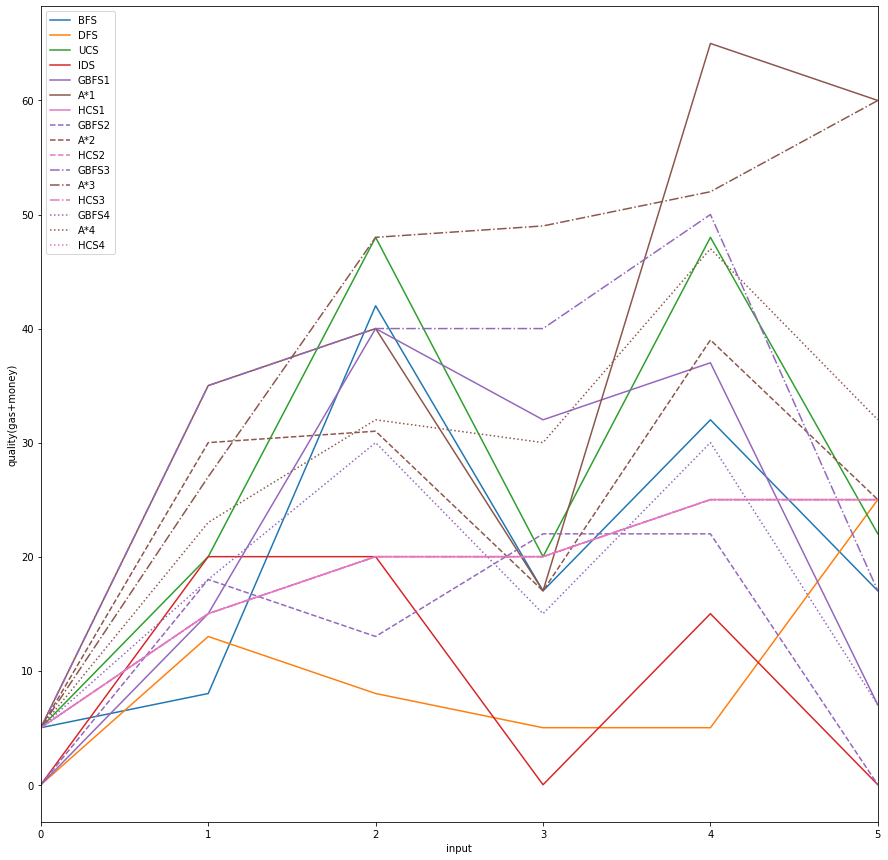

In [294]:
%matplotlib inline
plot_algorithms(quality, 'quality(gas+money)')

There is no obvious hierarchy here, as each input leads to a very different set of solutions. Let's see the overall
(total) value for each algorithm:

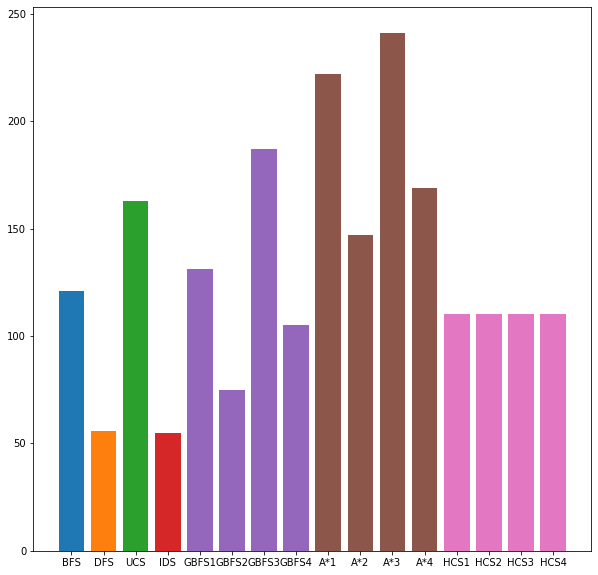

In [295]:
%matplotlib inline
plt.figure(figsize=(10,10))
colors = ['C0', 'C1', 'C2', 'C3',
          'C4', 'C4', 'C4', 'C4',
          'C5', 'C5', 'C5', 'C5',
          'C6', 'C6', 'C6', 'C6']
plt.bar(quality.keys(), list(map(sum, quality.values())), color=colors)
plt.show()

We now have a clearer idea about the difference in quality among the results given by the different algorithms.  
**UCS** is the clear winner among the ***uninformed search strategies*** as far as the quality of the solution is
concerned. **BFS** has decent results, while both **DFS** and **IDS** have a bad overall quality.  
As for the ***informed search strategies***, the heuristics which take the budget into account (`h2`, `h4`) give worse
results than the counterparts that don't. The heuristics that take into account the distance to the client's
destination (`h3`, `h4`) also give better result that the counterparts that don't. Overall, for the given input, the
hierarchy seems to be `h3` > `h1` > `h4` > `h2`.  
**A*** and **GBFS** both give great results (with **A***'s being better), while **HCS**, as expected, gives sub-par
results and is not affected by the heuristic.

### States

Speed should be directly related to the number of visited states.

In [81]:
visited['BFS'] = list(map(lambda x: visited_states(*optimized_bfs(x)), data))

In [82]:
visited['DFS'] = list(map(lambda x: visited_states(*optimized_dfs(x)), data))

In [83]:
visited['UCS'] = list(map(lambda x: visited_states(*optimized_ucs(x)), data))

In [175]:
visited['IDS'] = list(map(lambda x: visited_states(*optimized_ids(x)), data))

In [85]:
visited['GBFS1'] = list(map(lambda x: visited_states(*optimized_gbfs(x, h1)), data))

In [86]:
visited['GBFS2'] = list(map(lambda x: visited_states(*optimized_gbfs(x, h2)), data))

In [264]:
visited['GBFS3'] = list(map(lambda x: visited_states(*optimized_gbfs(x, h3)), data))

In [265]:
visited['GBFS4'] = list(map(lambda x: visited_states(*optimized_gbfs(x, h4)), data))

In [87]:
visited['A*1'] = list(map(lambda x: visited_states(*optimized_a_star(x, h1)), data))

In [88]:
visited['A*2'] = list(map(lambda x: visited_states(*optimized_a_star(x, h2)), data))

In [266]:
visited['A*3'] = list(map(lambda x: visited_states(*optimized_a_star(x, h3)), data))

In [268]:
visited['A*4'] = list(map(lambda x: visited_states(*optimized_a_star(x, h4)), data))

In [89]:
visited['HCS1'] = list(map(lambda x: visited_states(*optimized_hcs(x, h1)), data))

In [269]:
visited['HCS2'] = list(map(lambda x: visited_states(*optimized_hcs(x, h2)), data))

In [270]:
visited['HCS3'] = list(map(lambda x: visited_states(*optimized_hcs(x, h3)), data))

In [271]:
visited['HCS4'] = list(map(lambda x: visited_states(*optimized_hcs(x, h4)), data))

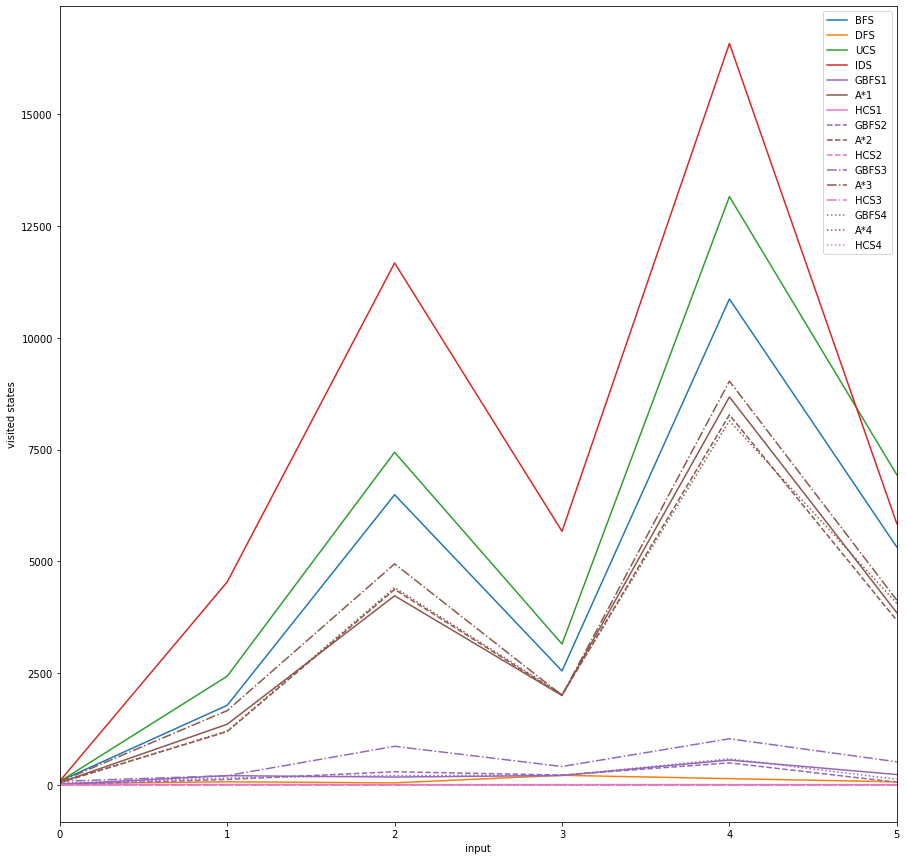

In [272]:
%matplotlib inline
plot_algorithms(visited, 'visited states')

As expected, the number of visited states is tightly linked to the performance. The only 'out of line' result is
**IDS**, but that is simply because many of those states are duplicated (due to calling **DLS** multiple times) and the
intermediary result is most likely cached, leading to a better performance per 'visited' state.

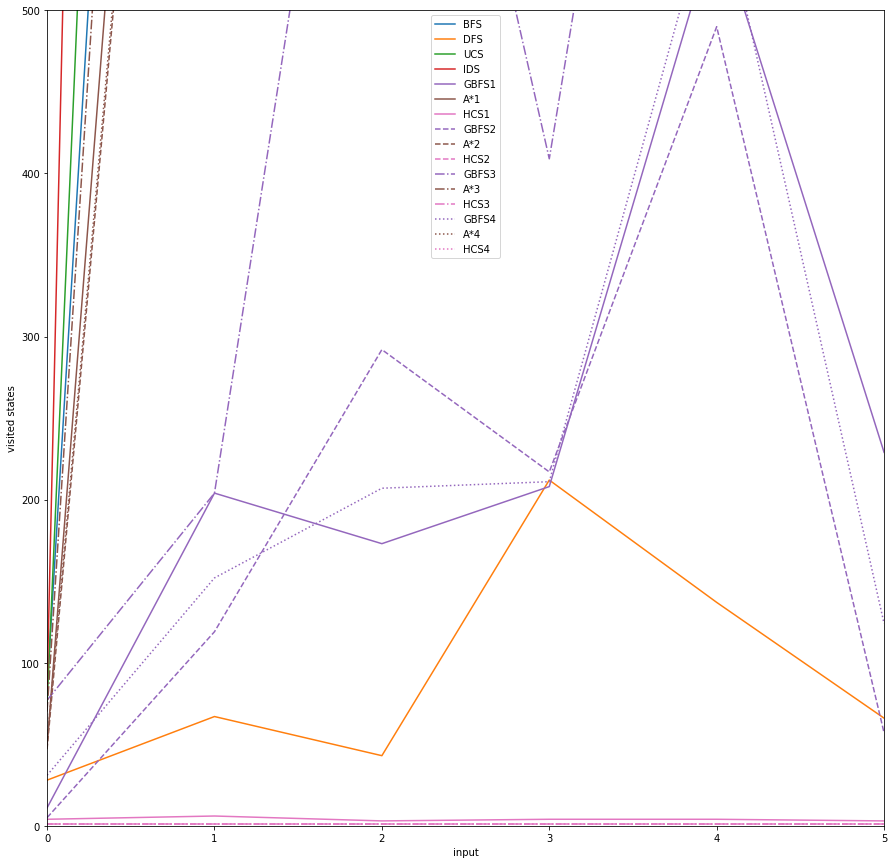

In [273]:
%matplotlib inline
plot_algorithms(visited, 'visited states', [0, 5],[0,500])

The third heuristic leads to more visited states (hence the worse performance), while the others don't not seem to
consistently and significantly affect the number of visited states.

## Conclusion

There are tradeoffs with each algorithm, there is no 'clearly better' search strategy for this particular problem.

Among the ***uninformed search strategies***, **Uniform Cost Search** is the slowest, but overall gives the most optimal
solutions (comparable even with the ones given by informed searches). **Breadth first search** is average both in terms
of speed and quality, while **Depth first search** and **Depth limited search** are very fast but give non-optimal
solutions.

For the ***informed search strategies***, we used two similar heuristics: one that calculated the Manhattan distance to
the nearest point of interest (be it the passenger's destination or the nearest potential client), and one that also
took the potential client's budget into account so that a client that is further away would have less of an impact if it
has a larger available budget. We then improved those heuristics to also take into account the distance to the client's
destination.  
The third heuristic lead to the best results, while the heuristic that divided the distances by the client's budget lead
to significantly less optimal results, meaning that prioritizing the budget this way is not efficient for our problem.

**A*** is significantly slower than the other informed strategies, but gives better results. **Greedy best-first
search** is very fast and gives good results, and **Hill climbing search** is faster but gives worse results.